In [143]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (9,8)
mpl.rcParams['font.size'] = 25.0

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=True)

In [2]:
# Set the random seed
np.random.seed(int((time.time()%1)*1.0e8))

### Basic quantum mechanics review

---

$$
H = \frac{\vec{p}^2}{2m} + V(\vec{r})
$$
where H is the Hamiltonian (energy) and V is the potential, like $-k/r$ for electrostatics.  We make the following substitutions

$$
\vec{p} = -i\hbar \nabla
$$
where $\vec{p}$ is the momentum vector
and
$$
t = i\hbar \frac{\delta}{\delta t}
$$
and t is time.

From this, we get Schrodinger's equation for the wavefunction:
$$
i\hbar \frac{\delta \psi(\vec{r},t)}{\delta t} = \frac{-\hbar^2}{2m} \nabla^2\psi(\vec{r},t) + V(\vec{r})\psi(\vec{r},t).
$$

From the law of total probability, we get
$$
\int |\psi|^2 dxdydx = 1
$$
which makes it like a probability distribution.

For bound systems, eigenvalues are discrete while for free systems, eigenvalues are continuous.

---

For the hydrogen atom (in cgs units),
$$
V(\vec{r}) = \frac{-e^2}{r}
$$
is the potential and the energy levels go like
$$
E_n = \frac{-e^2}{2 a_0 n^2}
$$
for Bohr radius $a_0$ and interger $n$.

For the ground state, they kind of look like this
$$
R_{10}(r) = 2\frac{1}{a_0}^{3/2}e^{r/a_0}
$$
where 1 is the principal quantum number $n$ and 0 is the angular momentum quantum number $l$ in the ground state.

The probability that an electron in the ground state is between $r$ and $dr$ is proportional to 
$$
4 \pi r^2 |R_{10}(r)|^2 dr.
$$

Note: the Pauli Exclusion Principle states that two fermions (like electrons with spin $1/2$) cannot occupy the same quantum state.

The wavefunction for two identical fermions (electrons) is antisymmetric with respect to exchange of the particles.  This means that the wavefunction changes sign if the space and spin coordinates of any particles are interchanged.

### Variational Quantum Monte Carlo

---
$$
H \psi(\vec{R}) = E_0 \psi(\vec{R})
$$
where $\vec{R}$ contains position and velocity vectors for all particles involved.  Then, we sum the hamiltonian with some interaction term between the particles.

We can estimate an upper bound by doing something like
$$
E_{var} = \frac{\int \psi_T^* H \psi_T d\vec{R}}{|\psi(\vec{R})|^2 d\vec{R}}
$$
where $\psi_T$ is some trial wavefunction with some parameters.  This is effectively an optimization problem, so MCMC works well.

### Homework 7 Scratch

---

Self-avoiding random walk on a 3d lattice.  A decent model of a dilute solution of polymers in a good solvent.

Acceptance = A/num_runs so only a small number of the chains will not have a self-intersection and will be accepted.  Error grows faster than a usual random walk which scales as N.

In [133]:
def self_avoiding_random_walk(steps):
    bFirstStep = True
    
    history = [(0,0,0)] # Contains history of steps (tuples of (x,y,z)) we wish to avoid
    
    i = 0 # step counter
    
    # Directions for 3d lattice
    new = [xx for xx in range(1,7)]
    
    # Initial position
    x = 0
    y = 0
    z = 0
    past = 0
    
    #Run the random walk starting from the origin, (0,0,0)
    for i in range(0,steps):
        
        if bFirstStep: # Can go any of 6 ways initially
            prob = 1./6. # Probability of moving a given direction
            
            # Get random number
            r = np.random.uniform(0.0,1.0)
            
            # Pick a direction
            if r <= prob:
                x = x + 1 # Go right
                past = 1
            elif r > prob and r <= 2.0*prob:
                x = x - 1 # Go left
                past = 2
            elif r > 2.0*prob and r <= 3.0*prob:
                y = y + 1 # Go top
                past = 3
            elif r > 3.0*prob and r <= 4.0*prob:
                y = y - 1 # Go bottom
                past = 4
            elif r > 4.0*prob and r < 5.0*prob:
                z = z + 1 # Go up
                past = 5
            else:
                z = z - 1 # Go down
                past = 6
                
            # Add this step to step history
            history.append((x,y,z))
            
            # Not the first step anymore
            bFirstStep = False
            
        # Not first step, can only go 1 of 5 directions
        else:
            # Exclude the past direction
            new.remove(past)
            
            old_past = past # Cache past step
            
            prob = 1./5. # Probability to move in a given direction
            
            # Get random number
            r = np.random.uniform(0.0,1.0)
            
            # Loop over directions
            for i in range(0,len(new)):
                if r > i*prob and r <= (i+1)*prob:
                    next_step = new[i]
                    break
            
            # Now step, save which direction you step
            if next_step == 1:
                x = x + 1 # Go right
                past = 1
            elif next_step == 2:
                x = x - 1 # Go left
                past = 2
            elif next_step == 3:
                y = y + 1 # Go top
                past = 3
            elif next_step == 4:
                y = y - 1 # Go bottom
                past = 4
            elif next_step == 5:
                z = z + 1 # Go up
                past = 5
            else:
                z = z - 1 # Go down
                past = 6
                        
            # Add old_past back to direction list
            new.append(old_past)
            
            # Now check if we've been here before
            current_position = (x,y,z)
            
            # Been there, reject this iteration
            if current_position in history:
                return [(0,0,0)], 0.0 
            # Haven't been there, add step and repeat
            else:
                # Add this step to your history
                history.append((x,y,z))
            
    # Simulation over: return final position and squared distance from origin
    return history[-1], (history[-1][0]**2 + history[-1][1]**2 + history[-1][2]**2)

In [157]:
def self_avoiding_ensemble(steps,N=10000):
    s2 = []
    acceptance = 0.0
    
    for i in range(0,N):
        tmps2 = self_avoiding_random_walk(steps)[1] # only save square distance from origin
        
        # Did it actually go anywhere? If so, save this
        if tmps2 > 0.0:
            acceptance = acceptance + 1.0
            s2.append(tmps2)
        
    # Return mean, std
    s2 = np.array(s2)
    return np.mean(s2), np.std(s2), acceptance/N

In [175]:
steps = np.array([5, 10, 15, 20, 25, 30])

means = np.zeros(len(steps))
stds = np.zeros(len(steps))
A = np.zeros(len(steps))

for i in range(0,len(steps)):
    means[i], stds[i], A[i] = self_avoiding_ensemble(steps[i],N=100000)

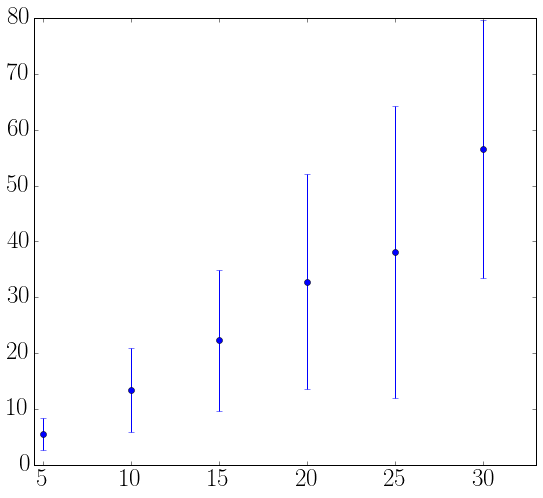

In [176]:
fig, ax = plt.subplots()

ax.errorbar(steps,means,yerr=stds,fmt="o")

ax.set_xlim(steps.min() - 0.1*steps.min(),steps.max() + 0.1*steps.max());

#ax.set_yscale("log")
#ax.set_xscale("log")